In [1]:
import numpy as np
import pandas as pd
import queue
import matplotlib.pyplot as plt

import sys
backtest_dir = 'C://backtest/backtest/'
if backtest_dir not in sys.path:
    sys.path.insert(0, backtest_dir)
    
from Backtest import *
from BayesianOptimization import *
from RSIStrategy import RSIStrategy
from Backtest.open_json_gz_files import open_json_gz_files
from Backtest.generate_bars import generate_bars

In [2]:
def run_backtest(config, trading_data, ohlc_data, window, s, b):
    window = int(window)
    s = int(s)
    b = int(b)
    config['title'] = "RSIStrategy" + "_" + str(window) + "_" + str(s) + "_" + str(b)
    print("---------------------------------")
    print(config['title'])
    print("---------------------------------")
    
    events_queue = queue.Queue()

    data_handler = OHLCDataHandler(
        config, events_queue,
        trading_data = trading_data, ohlc_data = ohlc_data
    )
    strategy = RSIStrategy(config, events_queue, data_handler,
                            window=window, s=s, b=b)

    backtest = Backtest(config, events_queue, strategy,
                        data_handler= data_handler)

    results = backtest.start_trading()
    
    # dict_ans = {
    #     "window": [window],
    #     "s": [s],
    #     "b": [b],
    #     "Sharpe Ratio": [results['sharpe']],
    #     "Total Returns": [(results['cum_returns'][-1] - 1)],
    #     "Max Drawdown": [(results["max_drawdown"] * 100.0)],
    #     "Max Drawdown Duration": [(results['max_drawdown_duration'])],
    #     "Trades": [results['trade_info']['trading_num']],
    #     "Trade Winning": [results['trade_info']['win_pct']],
    #     "Average Trade": [results['trade_info']['avg_trd_pct']],
    #     "Average Win": [results['trade_info']['avg_win_pct']],
    #     "Average Loss": [results['trade_info']['avg_loss_pct']],
    #     "Best Trade": [results['trade_info']['max_win_pct']],
    #     "Worst Trade": [results['trade_info']['max_loss_pct']],
    #     "Worst Trade Date": [results['trade_info']['max_loss_dt']],
    #     "Avg Days in Trade": [results['trade_info']['avg_dit']]
    # }
    # return pd.DataFrame(dict_ans)
    return (results['cum_returns'][-1] - 1)

## Setting

In [3]:
config = {
    "csv_dir": "C:/backtest/Binance",
    "out_dir": "C:/backtest/results/RSIStrategy",
    "title": "RSIStrategy",
    "is_plot": False,
    "save_plot": False,
    "save_tradelog": False,
    "start_date": pd.Timestamp("2017-07-01T00:0:00", freq = "60" + "T"),    # str(freq) + "T"
    "end_date": pd.Timestamp("2018-04-01T00:00:00", freq = "60" + "T"),
    "equity": 1.0,
    "freq": 60,      # min
    "commission_ratio": 0.001,
    "suggested_quantity": None,     # None or a value
    "max_quantity": None,           # None or a value, Maximum purchase quantity
    "min_quantity": None,           # None or a value, Minimum purchase quantity
    "min_handheld_cash": None,      # None or a value, Minimum handheld funds
    "exchange": "Binance",
    "tickers": ['BTCUSDT']
}

In [4]:
# trading_data = {}
# for ticker in config['tickers']:
#     # trading_data[ticker] = open_gz_files(config['csv_dir'], ticker)
#     trading_data[ticker] = pd.read_hdf(config['csv_dir'] + '\\' + ticker + '.h5', key=ticker)

ohlc_data = {}
for ticker in config['tickers']:
    # ohlc_data[ticker] = generate_bars(trading_data, ticker, config['freq'])
    ohlc_data[ticker] = pd.read_hdf(config['csv_dir'] + '\\' + ticker +'_OHLC_60min.h5', key=ticker)

trading_data = None

In [5]:
gp_params = {"alpha": 1e-5}

## Acquisition Function "Upper Confidence Bound"

* Prefer exploitation (kappa=1.0)

* Prefer exploration (kappa=10)


## Acquisition Function "Expected Improvement"

* Prefer exploitation (xi=1e-4)
* Prefer exploration (xi=0.1)

In [19]:
BO = BayesianOptimization(
    run_backtest,
    pbounds = {'window': (1, 120), 
               's': (55, 85),
              'b': (15, 45)},
    is_int = [1, 1, 1], 
    invariant = {
        'config': config,
        'trading_data': trading_data,
        'ohlc_data': ohlc_data
    },
    random_state = 1
)
# BO.explore({
#     'window': np.arange(1, 240, 24),
#     's': np.arange(95, 55, -4)
#     'b': np.arange(5, 45, 4)
#     },
#     eager=True)
BO.maximize(init_points=30, n_iter=60, acq="ei", xi=0.01, **gp_params)

Initialization
-----------------------------------------------------------------
 Step |   Time |      Value |         b |         s |    window | 
---------------------------------
RSIStrategy_38_64_18
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: nan
Max Drawdown: 0.0000000000
Max Drawdown Duration: 0
Total Returns: 0.0000000000
---------------------------------
Trades: 0
Trade Winning: N/A
Average Trade: N/A
Average Win: N/A
Average Loss: N/A
Best Trade: N/A
Worst Trade: N/A
Worst Trade Date: 0
Avg Days in Trade: 0
---------------------------------
    1 | 00m05s |    0.00000 | 18.000000 | 64.000000 | 38.000000 | 
---------------------------------
RSIStrategy_108_72_19
---------------------------------
Data Time 

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.5529212050
Max Drawdown: 43.7776567239
Max Drawdown Duration: 1696
Total Returns: 0.9479531294
---------------------------------
Trades: 526
Trade Winning: 69%
Average Trade: 0.36%
Average Win: 1.56%
Average Loss: -2.31%
Best Trade: 12.31%
Worst Trade: -11.41%
Worst Trade Date: 0 days 15:00:00
Avg Days in Trade: 0 days 03:31:29
---------------------------------
   11 | 00m05s |    0.94795 | 34.000000 | 77.000000 | 2.000000 | 
---------------------------------
RSIStrategy_77_80_24
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: nan
Max Drawdown: 0.0000000000
Max Drawdown Duration: 0
Total Returns: 0.0000000000
-------

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.0461722283
Max Drawdown: 51.3398267218
Max Drawdown Duration: 2723
Total Returns: -0.1354176069
---------------------------------
Trades: 79
Trade Winning: 67%
Average Trade: 0.18%
Average Win: 3.32%
Average Loss: -6.20%
Best Trade: 10.09%
Worst Trade: -19.64%
Worst Trade Date: 2 days 13:00:00
Avg Days in Trade: 1 days 00:03:02
---------------------------------
   22 | 00m06s |   -0.13542 | 41.000000 | 65.000000 | 12.000000 | 
---------------------------------
RSIStrategy_107_80_40
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.7400571109
Max Drawdown: 69.3396585403
Max Drawdown Duration: 2510
Total Returns: 0.226

---------------------------------
RSIStrategy_1_71_31
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: -0.5449028612
Max Drawdown: 48.9595048461
Max Drawdown Duration: 2736
Total Returns: -0.3385477557
---------------------------------
Trades: 1003
Trade Winning: 70%
Average Trade: 0.18%
Average Win: 0.99%
Average Loss: -1.75%
Best Trade: 6.90%
Worst Trade: -10.61%
Worst Trade Date: 0 days 07:00:00
Avg Days in Trade: 0 days 01:45:57
---------------------------------
   33 | 00m19s |   -0.33855 | 31.000000 | 71.000000 | 1.000000 | 
---------------------------------
RSIStrategy_4_56_43
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
-----

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: nan
Max Drawdown: 0.0000000000
Max Drawdown Duration: 0
Total Returns: 0.0000000000
---------------------------------
Trades: 0
Trade Winning: N/A
Average Trade: N/A
Average Win: N/A
Average Loss: N/A
Best Trade: N/A
Worst Trade: N/A
Worst Trade Date: 0
Avg Days in Trade: 0
---------------------------------
   43 | 00m10s |    0.00000 | 28.000000 | 72.000000 | 89.000000 | 
---------------------------------
RSIStrategy_10_62_37
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.7436003344
Max Drawdown: 42.6589274316
Max Drawdown Duration: 1176
Total Returns: 0.2283353277
---------------------------------
Trades: 102
Trad

---------------------------------
RSIStrategy_4_63_40
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.8762873002
Max Drawdown: 61.2795733767
Max Drawdown Duration: 2016
Total Returns: 0.3286894584
---------------------------------
Trades: 301
Trade Winning: 67%
Average Trade: 0.36%
Average Win: 2.03%
Average Loss: -3.04%
Best Trade: 12.05%
Worst Trade: -24.16%
Worst Trade Date: 1 days 09:00:00
Avg Days in Trade: 0 days 05:55:25
---------------------------------
   54 | 00m13s |    0.32869 | 40.000000 | 63.000000 | 4.000000 | 
---------------------------------
RSIStrategy_5_62_43
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
-------

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: -0.1832918260
Max Drawdown: 35.7124923936
Max Drawdown Duration: 568
Total Returns: -0.1284955394
---------------------------------
Trades: 1
Trade Winning: 100%
Average Trade: 20.34%
Average Win: 20.34%
Average Loss: nan%
Best Trade: 20.34%
Worst Trade: 20.34%
Worst Trade Date: 16 days 06:00:00
Avg Days in Trade: 16 days 06:00:00
---------------------------------
   64 | 00m17s |   -0.12850 | 38.000000 | 64.000000 | 107.000000 | 
---------------------------------
RSIStrategy_66_59_40
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.4725343016
Max Drawdown: 51.0608924369
Max Drawdown Duration: 1965
Total Returns: 0.07

---------------------------------
RSIStrategy_7_70_37
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.7501379668
Max Drawdown: 42.5027427055
Max Drawdown Duration: 1485
Total Returns: 0.2319687584
---------------------------------
Trades: 135
Trade Winning: 67%
Average Trade: 0.48%
Average Win: 2.83%
Average Loss: -4.40%
Best Trade: 12.18%
Worst Trade: -19.54%
Worst Trade Date: 2 days 12:00:00
Avg Days in Trade: 0 days 14:02:13
---------------------------------
   75 | 00m15s |    0.23197 | 37.000000 | 70.000000 | 7.000000 | 
---------------------------------
RSIStrategy_55_79_41
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
------

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: -0.4036646024
Max Drawdown: 36.2406649522
Max Drawdown Duration: 1406
Total Returns: -0.1424837327
---------------------------------
Trades: 2
Trade Winning: 0%
Average Trade: -7.95%
Average Win: nan%
Average Loss: -7.95%
Best Trade: -3.25%
Worst Trade: -12.66%
Worst Trade Date: 7 days 21:00:00
Avg Days in Trade: 10 days 00:30:00
---------------------------------
   85 | 00m15s |   -0.14248 | 36.000000 | 56.000000 | 88.000000 | 
---------------------------------
RSIStrategy_33_55_28
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: -0.4186255667
Max Drawdown: 27.9386443491
Max Drawdown Duration: 1429
Total Returns: -0.10

In [20]:
print(BO.res['max'])

{'max_val': 0.9479531294234564, 'max_params': {'window': 2.0, 's': 77.0, 'b': 34.0}}


In [21]:
BO.maximize(init_points=0, n_iter=60, acq="ei", xi=0.0001, **gp_params)

Bayesian Optimization
-----------------------------------------------------------------
 Step |   Time |      Value |         b |         s |    window | 
---------------------------------
RSIStrategy_12_68_15
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: -0.9417222369
Max Drawdown: 38.0739291965
Max Drawdown Duration: 1790
Total Returns: -0.2664463865
---------------------------------
Trades: 12
Trade Winning: 50%
Average Trade: -2.04%
Average Win: 4.23%
Average Loss: -8.31%
Best Trade: 8.76%
Worst Trade: -17.46%
Worst Trade Date: 3 days 21:00:00
Avg Days in Trade: 1 days 19:55:00
---------------------------------
   91 | 00m15s |   -0.26645 | 15.000000 | 68.000000 | 12.000000 | 
---------------------------------
R

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.7400571109
Max Drawdown: 69.3396585403
Max Drawdown Duration: 2510
Total Returns: 0.2260203529
---------------------------------
Trades: 0
Trade Winning: N/A
Average Trade: N/A
Average Win: N/A
Average Loss: N/A
Best Trade: N/A
Worst Trade: N/A
Worst Trade Date: 0
Avg Days in Trade: 0
---------------------------------
  101 | 00m15s |    0.22602 | 41.000000 | 84.000000 | 86.000000 | 
---------------------------------
RSIStrategy_111_80_41
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.7400571109
Max Drawdown: 69.3396585403
Max Drawdown Duration: 2510
Total Returns: 0.2260203529
---------------------------------
Tr

---------------------------------
RSIStrategy_85_71_44
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.7996639679
Max Drawdown: 64.7660466665
Max Drawdown Duration: 2419
Total Returns: 0.2806959699
---------------------------------
Trades: 1
Trade Winning: 100%
Average Trade: 199.99%
Average Win: 199.99%
Average Loss: nan%
Best Trade: 199.99%
Worst Trade: 199.99%
Worst Trade Date: 40 days 22:00:00
Avg Days in Trade: 40 days 22:00:00
---------------------------------
  112 | 00m18s |    0.28070 | 44.000000 | 71.000000 | 85.000000 | 
---------------------------------
RSIStrategy_79_75_44
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00


---------------------------------
RSIStrategy_40_85_45
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.7608919559
Max Drawdown: 69.3396585403
Max Drawdown Duration: 2510
Total Returns: 0.2446726626
---------------------------------
Trades: 1
Trade Winning: 100%
Average Trade: 45.52%
Average Win: 45.52%
Average Loss: nan%
Best Trade: 45.52%
Worst Trade: 45.52%
Worst Trade Date: 104 days 12:00:00
Avg Days in Trade: 104 days 12:00:00
---------------------------------
  123 | 00m17s |    0.24467 | 45.000000 | 85.000000 | 40.000000 | 
---------------------------------
RSIStrategy_81_85_45
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
--

---------------------------------
RSIStrategy_5_85_24
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.2510519366
Max Drawdown: 53.8755804774
Max Drawdown Duration: 2465
Total Returns: -0.0383941594
---------------------------------
Trades: 109
Trade Winning: 68%
Average Trade: 0.31%
Average Win: 3.08%
Average Loss: -5.54%
Best Trade: 9.90%
Worst Trade: -25.82%
Worst Trade Date: 2 days 12:00:00
Avg Days in Trade: 0 days 18:25:19
---------------------------------
  134 | 00m16s |   -0.03839 | 24.000000 | 85.000000 | 5.000000 | 
---------------------------------
RSIStrategy_63_71_15
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
------

---------------------------------
RSIStrategy_7_67_25
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.1693390886
Max Drawdown: 39.7121392672
Max Drawdown Duration: 2010
Total Returns: 0.4595010145
---------------------------------
Trades: 96
Trade Winning: 67%
Average Trade: 0.73%
Average Win: 3.34%
Average Loss: -4.48%
Best Trade: 16.42%
Worst Trade: -23.18%
Worst Trade Date: 1 days 09:00:00
Avg Days in Trade: 0 days 13:56:52
---------------------------------
  145 | 00m17s |    0.45950 | 25.000000 | 67.000000 | 7.000000 | 
---------------------------------
RSIStrategy_9_64_23
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
--------

In [22]:
print(BO.res['max'])

{'max_val': 0.9479531294234564, 'max_params': {'window': 2.0, 's': 77.0, 'b': 34.0}}


In [24]:
Target = pd.DataFrame({'Parameters': BO.X.tolist(), 'Target': BO.Y})
# Target.to_csv(config['out_dir'] + "/target_ei.csv")
Target.sort_values(by = "Target")

,Parameters,Target
17,"[21.0, 79.0, 30.0]",-0.638970
14,"[7.0, 83.0, 15.0]",-0.513284
41,"[17.0, 77.0, 33.0]",-0.474142
9,"[17.0, 84.0, 28.0]",-0.464189
72,"[39.0, 55.0, 44.0]",-0.408871
19,"[19.0, 74.0, 38.0]",-0.405820
45,"[33.0, 79.0, 32.0]",-0.369879
16,"[51.0, 63.0, 40.0]",-0.363961
24,"[30.0, 62.0, 37.0]",-0.363765
130,"[1.0, 55.0, 30.0]",-0.338548


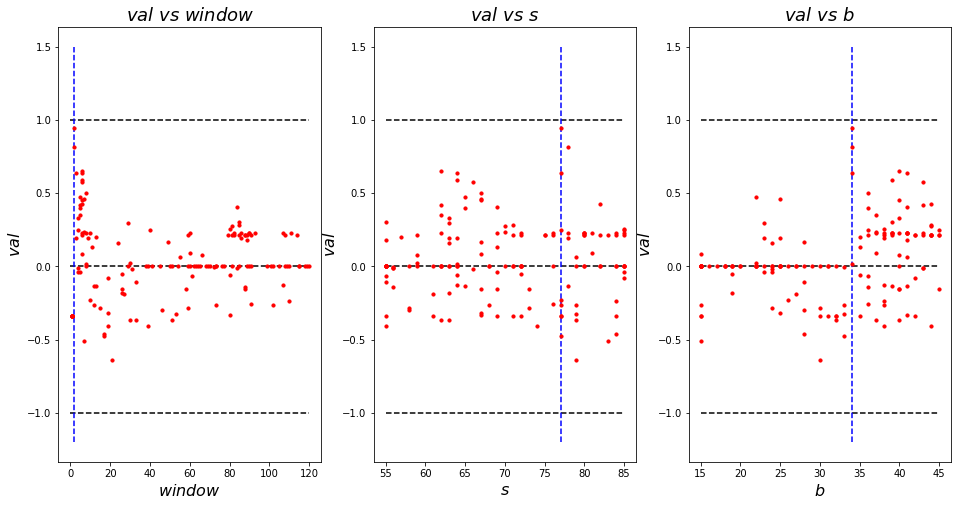

In [26]:
f, ax = plt.subplots(1,3, figsize = (16, 8))
ax[0].scatter(BO.X[:,0].flatten(), BO.Y, c="red", s=10, zorder=10)
ax[0].set_title('$val$ $vs$ $window$ ', fontsize=18)
ax[0].set_xlabel('$window$', fontsize=16)
ax[0].set_ylabel('$val$', fontsize=16)
ax[0].hlines(0, 0, 120, color='black',linestyle="--")
ax[0].hlines(-1, 0, 120, color='black',linestyle="--")
ax[0].hlines(1, 0, 120, color='black',linestyle="--")
ax[0].vlines(BO.res['max']['max_params']['window'], -1.2, 1.5, color='blue',linestyle="--")

ax[1].scatter(BO.X[:,1].flatten(), BO.Y, c="red", s=10, zorder=10)
ax[1].set_title('$val$ $vs$ $s$ ', fontsize=18)
ax[1].set_xlabel('$s$', fontsize=16)
ax[1].set_ylabel('$val$', fontsize=16)
ax[1].hlines(0, 55, 85,color='black',linestyle="--")
ax[1].hlines(-1, 55, 85, color='black',linestyle="--")
ax[1].hlines(1, 55, 85,color='black',linestyle="--")
ax[1].vlines(BO.res['max']['max_params']['s'], -1.2, 1.5, color='blue',linestyle="--")

ax[2].scatter(BO.X[:,2].flatten(), BO.Y, c="red", s=10, zorder=10)
ax[2].set_title('$val$ $vs$ $b$ ', fontsize=18)
ax[2].set_xlabel('$b$', fontsize=16)
ax[2].set_ylabel('$val$', fontsize=16)
ax[2].hlines(0, 15, 45,color='black',linestyle="--")
ax[2].hlines(-1, 15, 45, color='black',linestyle="--")
ax[2].hlines(1, 15, 45,color='black',linestyle="--")
ax[2].vlines(BO.res['max']['max_params']['b'], -1.2, 1.5, color='blue',linestyle="--")

## Acquisition Function "Probability of Improvement"

* Prefer exploitation (xi=1e-4)
* Prefer exploration (xi=0.1)